정상 범위 기반 이상치 탐지를 실행합니다...
정상 범위 기반 이상치 탐지 시스템
파일 로딩 성공: /home/minjoo/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv
데이터 형태: (35, 15)
데이터 기간: 2024-01-15 08:30:15 ~ 2024-02-02 08:46:05

총 4개 행에서 이상치 발견
전체 데이터의 11.43%

파라미터별 이상치 요약:
  ILLUMINATION_UNIFORMITY: 4건 (11.4%)
  RETICLE_TEMP: 2건 (5.7%)

상세 이상치 정보 (처음 5개):

[이상치 1]
  행 인덱스: 23
  PNO: PS024
  장비 ID: PHO_003
  측정 시간: 2024-01-23 08:15:20
  이상 파라미터: ILLUMINATION_UNIFORMITY, RETICLE_TEMP
    - ILLUMINATION_UNIFORMITY: 97.800 (정상범위: 98 ~ 100)
    - RETICLE_TEMP: 23.060 (정상범위: 22.95 ~ 23.05)

[이상치 2]
  행 인덱스: 24
  PNO: PS025
  장비 ID: PHO_003
  측정 시간: 2024-01-23 08:16:05
  이상 파라미터: ILLUMINATION_UNIFORMITY
    - ILLUMINATION_UNIFORMITY: 97.900 (정상범위: 98 ~ 100)

[이상치 3]
  행 인덱스: 31
  PNO: PS032
  장비 ID: PHO_003
  측정 시간: 2024-02-01 12:30:25
  이상 파라미터: ILLUMINATION_UNIFORMITY, RETICLE_TEMP
    - ILLUMINATION_UNIFORMITY: 97.600 (정상범위: 98 ~ 100)
    - RETICLE_TEMP: 23.070 (정상범위: 22.95 ~ 23.05)

[이상치 4]
  행 인덱스: 32

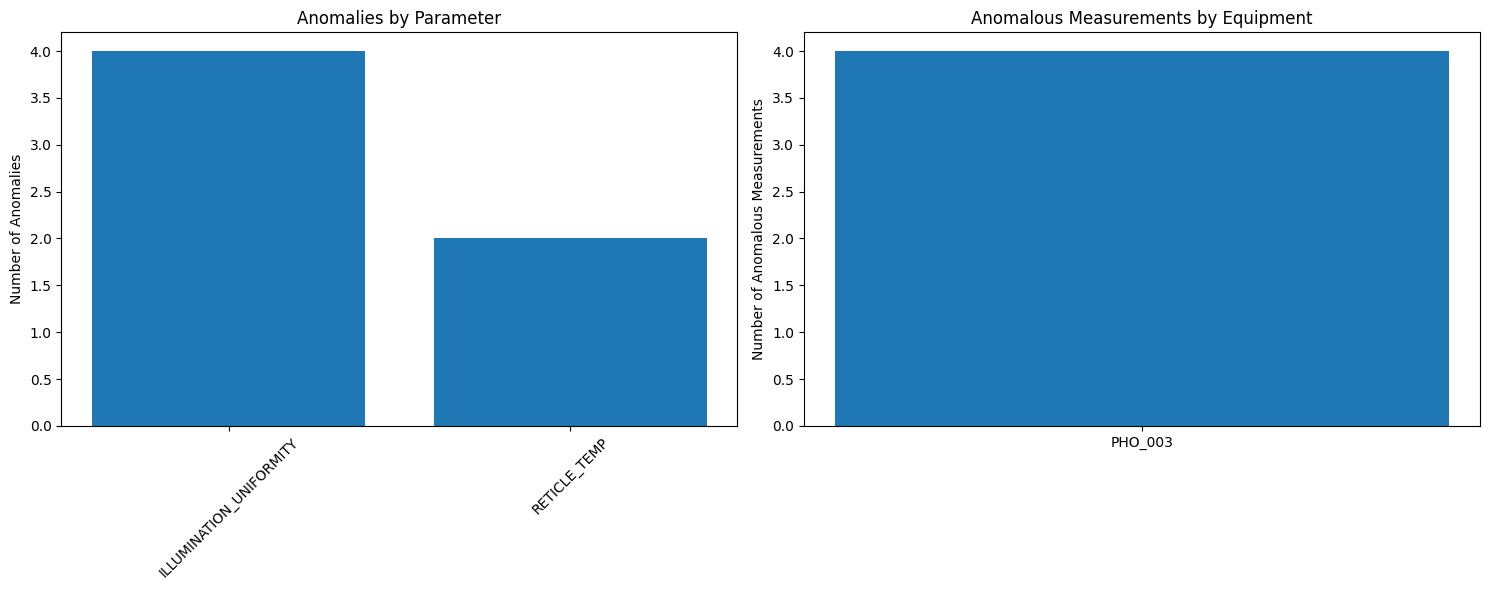


분석 완료!

최종 결과:
  총 데이터: 35행
  이상치: 4행 (11.43%)

탐지된 이상치 행 인덱스: [23, 24, 31, 32]
주요 이상 파라미터: {'ILLUMINATION_UNIFORMITY', 'RETICLE_TEMP'}


In [2]:
# 정상 범위 기반 이상치 탐지 함수
# SEMI_PHOTO_SENSORS 데이터 분석

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class RangeBasedAnomalyDetector:
    """정상 범위 기반 이상치 탐지 클래스"""
    
    def __init__(self, normal_ranges=None):
        """
        초기화
        
        Parameters:
        - normal_ranges: 정상 범위 딕셔너리 (선택사항)
        """
        self.normal_ranges = normal_ranges or {
            'EXPOSURE_DOSE': (20, 40),
            'FOCUS_POSITION': (-50, 50),
            'STAGE_TEMP': (22.9, 23.1),
            'HUMIDITY': (40, 50),
            'ALIGNMENT_ERROR_X': (0, 3),
            'ALIGNMENT_ERROR_Y': (0, 3),
            'LENS_ABERRATION': (0, 5),
            'ILLUMINATION_UNIFORMITY': (98, 100),
            'RETICLE_TEMP': (22.95, 23.05)
        }
    
    def detect_anomalies(self, df):
        """
        정상 범위를 벗어나는 이상치를 탐지
        
        Parameters:
        - df: 데이터프레임
        
        Returns:
        - anomaly_details: 이상치가 발견된 모든 행의 상세 정보
        - summary: 요약 정보
        """
        anomaly_details = []
        summary = {}
        
        # 각 행을 검사
        for idx, row in df.iterrows():
            row_anomalies = []
            
            # 각 파라미터에 대해 정상 범위 체크
            for param, (min_val, max_val) in self.normal_ranges.items():
                if param in row:
                    value = row[param]
                    if pd.notna(value) and (value < min_val or value > max_val):
                        row_anomalies.append({
                            'parameter': param,
                            'value': value,
                            'normal_min': min_val,
                            'normal_max': max_val,
                            'deviation': min(abs(value - min_val), abs(value - max_val))
                        })
            
            # 이상치가 발견된 행이면 상세 정보 저장
            if row_anomalies:
                anomaly_info = {
                    'row_index': idx,
                    'pno': row.get('PNO', 'N/A'),
                    'equipment_id': row.get('EQUIPMENT_ID', 'N/A'),
                    'lot_no': row.get('LOT_NO', 'N/A'),
                    'wafer_id': row.get('WAFER_ID', 'N/A'),
                    'timestamp': row.get('TIMESTAMP', 'N/A'),
                    'anomalous_parameters': [item['parameter'] for item in row_anomalies],
                    'anomaly_count': len(row_anomalies),
                    'anomaly_details': row_anomalies,
                    'full_row_data': row.to_dict()
                }
                anomaly_details.append(anomaly_info)
        
        # 요약 정보 생성
        for param in self.normal_ranges.keys():
            param_anomalies = [detail for detail in anomaly_details 
                              if param in detail['anomalous_parameters']]
            summary[param] = {
                'anomaly_count': len(param_anomalies),
                'percentage': (len(param_anomalies) / len(df)) * 100 if len(df) > 0 else 0
            }
        
        return anomaly_details, summary
    
    def analyze_by_equipment(self, df, anomaly_details):
        """장비별 이상치 분석"""
        equipment_analysis = {}
        
        for anomaly in anomaly_details:
            equipment = anomaly['equipment_id']
            if equipment not in equipment_analysis:
                equipment_analysis[equipment] = {
                    'total_anomalies': 0,
                    'anomalous_measurements': 0,
                    'parameters': {}
                }
            
            equipment_analysis[equipment]['anomalous_measurements'] += 1
            equipment_analysis[equipment]['total_anomalies'] += anomaly['anomaly_count']
            
            for param in anomaly['anomalous_parameters']:
                if param not in equipment_analysis[equipment]['parameters']:
                    equipment_analysis[equipment]['parameters'][param] = 0
                equipment_analysis[equipment]['parameters'][param] += 1
        
        # 총 측정 수 추가
        for equipment in equipment_analysis.keys():
            if 'EQUIPMENT_ID' in df.columns:
                total_measurements = len(df[df['EQUIPMENT_ID'] == equipment])
                equipment_analysis[equipment]['total_measurements'] = total_measurements
                equipment_analysis[equipment]['anomaly_rate'] = (
                    equipment_analysis[equipment]['anomalous_measurements'] / total_measurements * 100
                )
        
        return equipment_analysis
    
    def save_results(self, anomaly_details, filename='anomaly_results.csv'):
        """이상치 탐지 결과를 CSV 파일로 저장"""
        if not anomaly_details:
            print("저장할 이상치 데이터가 없습니다.")
            return False
        
        rows = []
        for anomaly in anomaly_details:
            base_info = {
                'row_index': anomaly['row_index'],
                'pno': anomaly['pno'],
                'equipment_id': anomaly['equipment_id'],
                'lot_no': anomaly['lot_no'],
                'wafer_id': anomaly['wafer_id'],
                'timestamp': anomaly['timestamp'],
                'anomaly_count': anomaly['anomaly_count'],
                'anomalous_parameters': ', '.join(anomaly['anomalous_parameters'])
            }
            base_info.update(anomaly['full_row_data'])
            rows.append(base_info)
        
        results_df = pd.DataFrame(rows)
        results_df.to_csv(filename, index=False, encoding='utf-8')
        print(f"이상치 결과 저장됨: {filename}")
        return True
    
    def visualize_anomalies(self, summary, equipment_analysis=None, save_plot=True):
        """이상치 시각화"""
        param_counts = {param: info['anomaly_count'] for param, info in summary.items() 
                       if info['anomaly_count'] > 0}
        
        if not param_counts:
            print("시각화할 이상치가 없습니다.")
            return
        
        if equipment_analysis:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        
        # 파라미터별 이상치 개수
        ax1.bar(param_counts.keys(), param_counts.values())
        ax1.set_title('Anomalies by Parameter')
        ax1.set_ylabel('Number of Anomalies')
        ax1.tick_params(axis='x', rotation=45)
        
        # 장비별 이상치 개수
        if equipment_analysis:
            equipment_counts = {eq: analysis['anomalous_measurements'] 
                              for eq, analysis in equipment_analysis.items()}
            if equipment_counts:
                ax2.bar(equipment_counts.keys(), equipment_counts.values())
                ax2.set_title('Anomalous Measurements by Equipment')
                ax2.set_ylabel('Number of Anomalous Measurements')
        
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('range_based_anomalies.png', dpi=300, bbox_inches='tight')
            print("시각화 저장됨: range_based_anomalies.png")
        
        plt.show()


def detect_range_based_anomalies(file_path, 
                                 normal_ranges=None, 
                                 start_time=None, 
                                 end_time=None,
                                 verbose=True,
                                 save_results=False,
                                 visualize=False,
                                 output_filename=None):
    """
    정상 범위 기반 이상치 탐지 메인 함수
    
    Parameters:
    - file_path: CSV 파일 경로
    - normal_ranges: 정상 범위 딕셔너리 (선택사항)
    - start_time: 시작 시간 (선택사항)
    - end_time: 종료 시간 (선택사항)  
    - verbose: 상세 출력 여부
    - save_results: 결과 저장 여부
    - visualize: 시각화 여부
    - output_filename: 출력 파일명
    
    Returns:
    - result: 분석 결과 딕셔너리
    """
    
    try:
        # 1. 데이터 로딩
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"파일을 찾을 수 없습니다: {file_path}")
        
        df = pd.read_csv(file_path)
        
        if verbose:
            print("=" * 80)
            print("정상 범위 기반 이상치 탐지 시스템")
            print("=" * 80)
            print(f"파일 로딩 성공: {file_path}")
            print(f"데이터 형태: {df.shape}")
        
        # TIMESTAMP 컬럼 처리
        if 'TIMESTAMP' in df.columns:
            df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
            
            if verbose:
                print(f"데이터 기간: {df['TIMESTAMP'].min()} ~ {df['TIMESTAMP'].max()}")
        
        # 시간 필터링
        if start_time or end_time:
            if 'TIMESTAMP' not in df.columns:
                print("경고: TIMESTAMP 컬럼이 없어 시간 필터링을 건너뜁니다.")
            else:
                if start_time:
                    start_time = pd.to_datetime(start_time)
                    df = df[df['TIMESTAMP'] >= start_time]
                if end_time:
                    end_time = pd.to_datetime(end_time)
                    df = df[df['TIMESTAMP'] <= end_time]
                
                if len(df) == 0:
                    return {"message": "지정된 시간 구간에 데이터가 없습니다.", "anomalies": []}
                
                if verbose:
                    print(f"시간 필터링 후 데이터: {df.shape[0]}행")
        
        # 2. 이상치 탐지 실행
        detector = RangeBasedAnomalyDetector(normal_ranges)
        anomaly_details, summary = detector.detect_anomalies(df)
        
        # 3. 장비별 분석
        equipment_analysis = None
        if 'EQUIPMENT_ID' in df.columns:
            equipment_analysis = detector.analyze_by_equipment(df, anomaly_details)
        
        # 4. 결과 출력
        if verbose:
            print(f"\n총 {len(anomaly_details)}개 행에서 이상치 발견")
            print(f"전체 데이터의 {(len(anomaly_details)/len(df)*100):.2f}%")
            
            # 파라미터별 요약
            print("\n파라미터별 이상치 요약:")
            has_anomalies = False
            for param, info in summary.items():
                if info['anomaly_count'] > 0:
                    print(f"  {param}: {info['anomaly_count']}건 ({info['percentage']:.1f}%)")
                    has_anomalies = True
            
            if not has_anomalies:
                print("  모든 파라미터가 정상 범위 내에 있습니다.")
            
            # 상세 이상치 정보 (처음 5개만)
            if anomaly_details:
                print(f"\n상세 이상치 정보 (처음 5개):")
                for i, anomaly in enumerate(anomaly_details[:5], 1):
                    print(f"\n[이상치 {i}]")
                    print(f"  행 인덱스: {anomaly['row_index']}")
                    print(f"  PNO: {anomaly['pno']}")
                    print(f"  장비 ID: {anomaly['equipment_id']}")
                    print(f"  측정 시간: {anomaly['timestamp']}")
                    print(f"  이상 파라미터: {', '.join(anomaly['anomalous_parameters'])}")
                    
                    for detail in anomaly['anomaly_details']:
                        print(f"    - {detail['parameter']}: {detail['value']:.3f} "
                              f"(정상범위: {detail['normal_min']} ~ {detail['normal_max']})")
                
                if len(anomaly_details) > 5:
                    print(f"\n... 외 {len(anomaly_details) - 5}개 더")
            
            # 장비별 분석
            if equipment_analysis:
                print(f"\n장비별 이상치 분석:")
                for equipment, analysis in equipment_analysis.items():
                    print(f"  {equipment}:")
                    print(f"    총 측정: {analysis['total_measurements']}회")
                    print(f"    이상 측정: {analysis['anomalous_measurements']}회 "
                          f"({analysis['anomaly_rate']:.1f}%)")
                    
                    if analysis['parameters']:
                        top_param = max(analysis['parameters'], key=analysis['parameters'].get)
                        print(f"    주요 이상 파라미터: {top_param} ({analysis['parameters'][top_param]}회)")
        
        # 5. 결과 저장
        if save_results:
            filename = output_filename or 'range_based_anomaly_results.csv'
            detector.save_results(anomaly_details, filename)
        
        # 6. 시각화
        if visualize and anomaly_details:
            detector.visualize_anomalies(summary, equipment_analysis)
        
        # 7. 결과 반환
        result = {
            'total_rows': len(df),
            'anomaly_count': len(anomaly_details),
            'anomaly_rate': (len(anomaly_details) / len(df)) * 100 if len(df) > 0 else 0,
            'anomalies': anomaly_details,
            'summary': summary,
            'equipment_analysis': equipment_analysis,
            'normal_ranges': detector.normal_ranges
        }
        
        if verbose:
            print(f"\n{'='*80}")
            print("분석 완료!")
            print(f"{'='*80}")
        
        return result
        
    except Exception as e:
        error_msg = f"오류 발생: {str(e)}"
        if verbose:
            print(error_msg)
        return {"error": error_msg, "anomalies": []}


def detect_anomalies_from_dataframe(df, 
                                   normal_ranges=None,
                                   start_time=None,
                                   end_time=None,
                                   verbose=False):
    """
    DataFrame에서 직접 이상치 탐지
    
    Parameters:
    - df: 데이터프레임
    - normal_ranges: 정상 범위 딕셔너리
    - start_time: 시작 시간
    - end_time: 종료 시간
    - verbose: 상세 출력 여부
    
    Returns:
    - anomaly_details: 이상치 목록
    - summary: 요약 정보
    """
    
    try:
        # 시간 필터링
        filtered_df = df.copy()
        if (start_time or end_time) and 'TIMESTAMP' in df.columns:
            df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
            if start_time:
                start_time = pd.to_datetime(start_time)
                filtered_df = filtered_df[filtered_df['TIMESTAMP'] >= start_time]
            if end_time:
                end_time = pd.to_datetime(end_time)
                filtered_df = filtered_df[filtered_df['TIMESTAMP'] <= end_time]
        
        # 이상치 탐지
        detector = RangeBasedAnomalyDetector(normal_ranges)
        anomaly_details, summary = detector.detect_anomalies(filtered_df)
        
        if verbose:
            print(f"총 {len(anomaly_details)}개 이상치 탐지됨")
            for param, info in summary.items():
                if info['anomaly_count'] > 0:
                    print(f"  {param}: {info['anomaly_count']}건")
        
        return anomaly_details, summary
        
    except Exception as e:
        if verbose:
            print(f"오류 발생: {str(e)}")
        return [], {}


# ===================================================================
# 사용 예시 및 메인 실행부
# ===================================================================

if __name__ == "__main__":
    # 기본 설정
    CSV_FILE_PATH = '/home/minjoo/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv'
    
    # 사용자 정의 정상 범위 (선택사항)
    custom_ranges = {
        'EXPOSURE_DOSE': (20, 40),
        'FOCUS_POSITION': (-50, 50),
        'STAGE_TEMP': (22.9, 23.1),
        'HUMIDITY': (40, 50),
        'ALIGNMENT_ERROR_X': (0, 3),
        'ALIGNMENT_ERROR_Y': (0, 3),
        'LENS_ABERRATION': (0, 5),
        'ILLUMINATION_UNIFORMITY': (98, 100),
        'RETICLE_TEMP': (22.95, 23.05)
    }
    
    # 메인 함수 실행
    print("정상 범위 기반 이상치 탐지를 실행합니다...")
    
    result = detect_range_based_anomalies(
        file_path=CSV_FILE_PATH,
        normal_ranges=custom_ranges,
        start_time=None,  # '2024-01-15 08:00:00'
        end_time=None,    # '2024-01-16 09:00:00'
        verbose=True,
        save_results=True,
        visualize=True,
        output_filename='detected_anomalies.csv'
    )
    
    # 결과 확인
    if 'error' not in result:
        print(f"\n최종 결과:")
        print(f"  총 데이터: {result['total_rows']}행")
        print(f"  이상치: {result['anomaly_count']}행 ({result['anomaly_rate']:.2f}%)")
        
        # 이상치가 있으면 간단한 요약 출력
        if result['anomalies']:
            print(f"\n탐지된 이상치 행 인덱스: {[a['row_index'] for a in result['anomalies'][:10]]}")
            print(f"주요 이상 파라미터: {set().union(*[a['anomalous_parameters'] for a in result['anomalies']])}")
    else:
        print(f"오류: {result['error']}")

간단 사용법:

1. 기본 사용:
result = detect_range_based_anomalies('your_file.csv')

2. 시간 구간 지정:
result = detect_range_based_anomalies('your_file.csv', 
                                     start_time='2024-01-15', 
                                     end_time='2024-01-16')

3. 사용자 정의 정상 범위:
custom_ranges = {'EXPOSURE_DOSE': (25, 35)}
result = detect_range_based_anomalies('your_file.csv', normal_ranges=custom_ranges)

4. DataFrame에서 직접 사용:
anomalies, summary = detect_anomalies_from_dataframe(df)

5. 결과 저장 및 시각화:
result = detect_range_based_anomalies('your_file.csv', 
                                     save_results=True, 
                                     visualize=True)